  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1970-01-19T00:00:00.665000       0.000000  -6.150000e-14
1     1970-01-19T00:00:00.815943       0.150943  -7.700000e-14
2     1970-01-19T00:00:00.966887       0.301887  -8.400000e-14
3     1970-01-19T00:00:01.117830       0.452830  -8.100000e-14
4     1970-01-19T00:00:01.268774       0.603774  -7.100000e-14


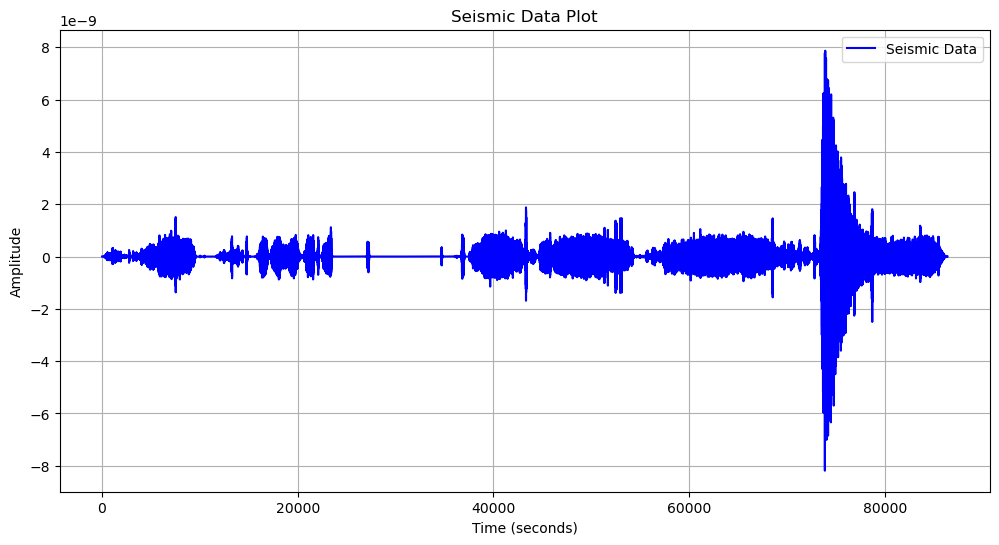

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('xa.s12.00.mhz.1970-01-19HR00_evid00002example.csv')

# Display the first few rows to understand its structure
print(data.head())

# The dataset tested had the columns named as "time_rel(sec)" and veclocity(sec), change as required  
time_column = 'time_rel(sec)'  
value_column = 'velocity(m/s)'  

# Plot the original data
plt.figure(figsize=(12, 6))
plt.plot(data[time_column], data[value_column], color='blue', label='Seismic Data')
plt.title('Seismic Data Plot')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


In [17]:
import pandas as pd
import numpy as np
import pywt

# Apply wavelet transform to the relevant column (adjust the column name as needed)
coeffs = pywt.wavedec(data['velocity(m/s)'], 'db4', level=6)

# Create time absolute and relative columns
time_abs = data['time_abs(%Y-%m-%dT%H:%M:%S.%f)']
time_rel = (pd.to_datetime(time_abs) - pd.to_datetime(time_abs.iloc[0])).dt.total_seconds()

# Create a dictionary to store wavelet coefficients by level (VERYYYYYY IMPORTANT)
wavelet_data = {
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': time_abs,
    'time_rel(sec)': time_rel
}

# Add each level's wavelet coefficients to the DataFrame
for i, coeff in enumerate(coeffs):
    wavelet_data[f'wavelet_coefficients_level_{i}'] = np.pad(coeff, (0, len(time_abs) - len(coeff)), mode='constant', constant_values=np.nan)

# Create the DataFrame with the wavelet coefficients organized by level
wavelet_df = pd.DataFrame(wavelet_data)

# Save the DataFrame to a CSV file
wavelet_df.to_csv('wavelet_coefficients_by_level.csv', index=False)

print("Wavelet coefficients by level saved to 'wavelet_coefficients_by_level.csv'.")


Wavelet coefficients by level saved to 'wavelet_coefficients_by_level.csv'.


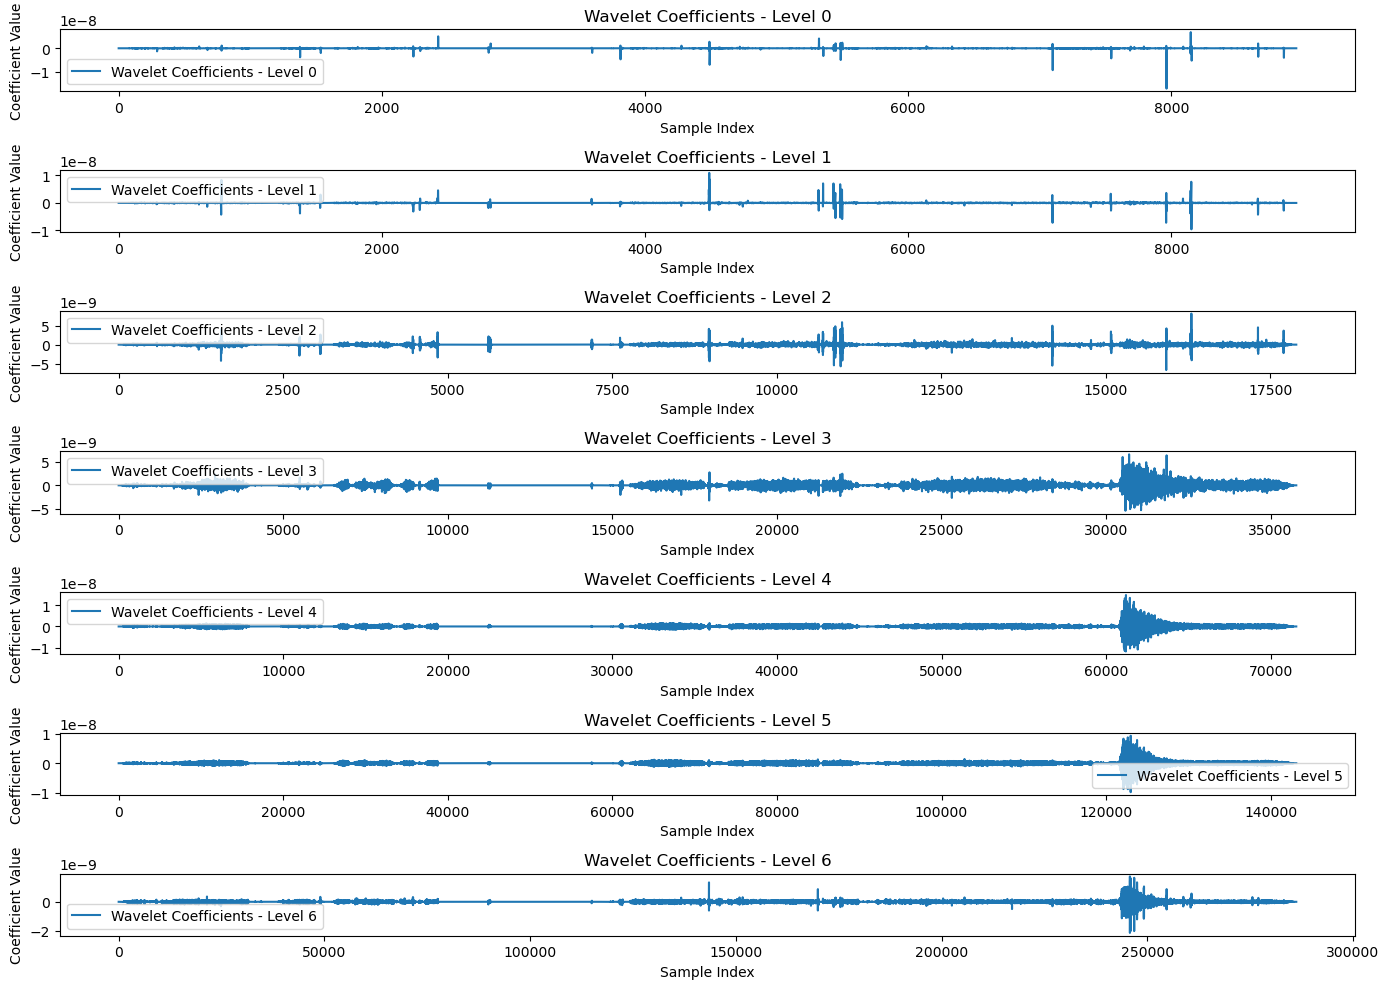

In [19]:
import matplotlib.pyplot as plt

# Create a figure to plot the coefficients
plt.figure(figsize=(14, 10))

# Plot each level of coefficients
for i, coeff in enumerate(coeffs):
    plt.subplot(len(coeffs), 1, i + 1)
    plt.plot(coeff, label=f'Wavelet Coefficients - Level {i}')
    plt.title(f'Wavelet Coefficients - Level {i}')
    plt.xlabel('Sample Index')
    plt.ylabel('Coefficient Value')
    plt.legend()

plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np

# Load the wavelet coefficients CSV file
wavelet_df = pd.read_csv('wavelet_coefficients_by_level.csv')

# List to hold coefficient arrays for each level
coeffs = []
max_levels = 7  # Assuming you want to check for levels 0 to 6 (the 'resolution' so to say of this program goes from 0-6)

# Check and create arrays for each level
for level in range(max_levels):
    col_name = f'wavelet_coefficients_level_{level}'
    
    if col_name in wavelet_df.columns:
        # Get the coefficient array for this level
        coeff_array = wavelet_df[col_name].values
        
        # Find the last non-empty value's index
        last_valid_index = np.where(~np.isnan(coeff_array))[0][-1] if np.any(~np.isnan(coeff_array)) else -1
        
        if last_valid_index >= 0:
            # Slice the coefficient array to keep only the valid values
            trimmed_coeff_array = coeff_array[:last_valid_index + 1]
            coeffs.append(trimmed_coeff_array)
            print(f'Shape of {col_name}: {trimmed_coeff_array.shape}')  # Print the shape of each coefficient array
        else:
            print(f'No valid values found in {col_name}.')
    else:
        print(f'Column {col_name} does not exist in the DataFrame.')

# At this point, you have coeffs as a list containing arrays for each level
#Arrays are padded to avoid dimension errors

Shape of wavelet_coefficients_level_0: (8950,)
Shape of wavelet_coefficients_level_1: (8950,)
Shape of wavelet_coefficients_level_2: (17894,)
Shape of wavelet_coefficients_level_3: (35782,)
Shape of wavelet_coefficients_level_4: (71558,)
Shape of wavelet_coefficients_level_5: (143109,)
Shape of wavelet_coefficients_level_6: (286211,)


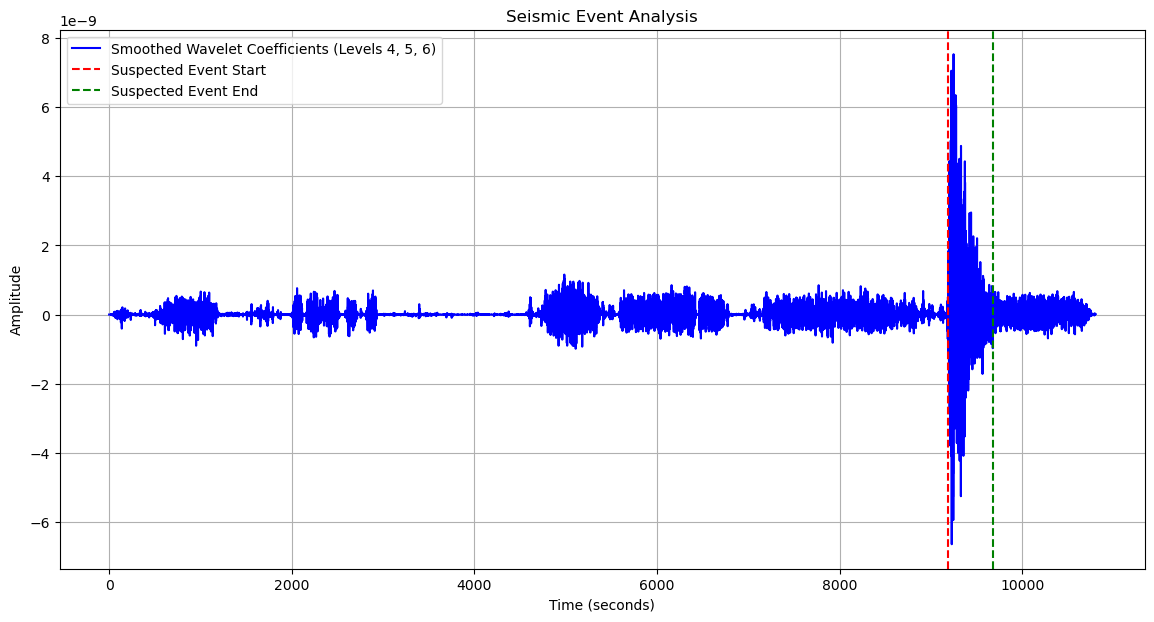

Smoothed wavelet coefficients saved to 'smoothed_wavelet_coefficients.csv_with_start_and_end'.
The suspected start of the seismic event is at: 9187.924528 seconds
The suspected end of the seismic event is at: 9676.830189 seconds


In [9]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# Load wavelet coefficients
wavelet_df = pd.read_csv('wavelet_coefficients_by_level.csv')

# Extract coefficients for levels 4, 5, and 6 (most common for quake levels)
level_4 = wavelet_df['wavelet_coefficients_level_4'].dropna().values
level_5 = wavelet_df['wavelet_coefficients_level_5'].dropna().values
level_6 = wavelet_df['wavelet_coefficients_level_6'].dropna().values

# Ensure the same length for all levels (padding)
min_length = min(len(level_4), len(level_5), len(level_6))
level_4 = level_4[:min_length]
level_5 = level_5[:min_length]
level_6 = level_6[:min_length]

# Combine coefficients
combined_coeffs = level_4 + level_5 + level_6

# Smooth the combined data
smoothed_data = gaussian_filter1d(combined_coeffs, sigma=2)

# Create time series for plotting
time_rel = wavelet_df['time_rel(sec)'].dropna().values[:min_length]

# Set a higher threshold for peak detection
mean_value = np.mean(smoothed_data)
std_value = np.std(smoothed_data)

######### for the start point
# Increase the multiplier significantly to further reduce false positives
threshold_value = mean_value + 4 * std_value  # Try increasing to 4 or 5 (Change as required)
minimum_peak_height = threshold_value  # Set a minimum height for detected peaks
minimum_peak_width = 10  # Set minimum width for detected peaks

# Find peaks to mark the start of seismic events
peaks, properties = find_peaks(smoothed_data, height=minimum_peak_height, distance=50, width=minimum_peak_width)

# Check if any peaks are found and use the first one for marking
event_start = peaks[0] if len(peaks) > 0 else None

########## for the end point
# Set a threshold for end detection
threshold = mean_value - 2.5 * std_value  # Adjust this value to your data characteristics (same as above)

# Start from the end of the signal and look for the end of the event
for i in range(min_length - 1, 0, -1):
    # Check if the amplitude is below the threshold for stability
    if smoothed_data[i] < threshold:
        event_end = i
        break
else:
    event_end = None

# Plot the smoothed data and mark the event start and end
plt.figure(figsize=(14, 7))
plt.plot(time_rel, smoothed_data, label='Smoothed Wavelet Coefficients (Levels 4, 5, 6)', color='blue')
if event_start is not None:
    plt.axvline(x=time_rel[event_start], color='red', label='Suspected Event Start', linestyle='--')
if event_end is not None:
    plt.axvline(x=time_rel[event_end], color='green', label='Suspected Event End', linestyle='--')
plt.title('Seismic Event Analysis')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

# Save the smoothed signal and time to CSV
output_df = pd.DataFrame({
    'time_rel(sec)': time_rel,
    'smoothed_wavelet_coefficients': smoothed_data
})

# Save to CSV
output_df.to_csv('smoothed_wavelet_coefficients.csv_with_start_and_end', index=False)

print("Smoothed wavelet coefficients saved to 'smoothed_wavelet_coefficients.csv_with_start_and_end'.")

# Check the x-values where the event start and end lines are drawn
if event_start is not None:
    event_start_time = time_rel[event_start]
    print(f"The suspected start of the seismic event is at: {event_start_time} seconds")
else:
    print("No event start detected.")

if event_end is not None:
    event_end_time = time_rel[event_end]
    print(f"The suspected end of the seismic event is at: {event_end_time} seconds")
else:
    print("No event end detected.")

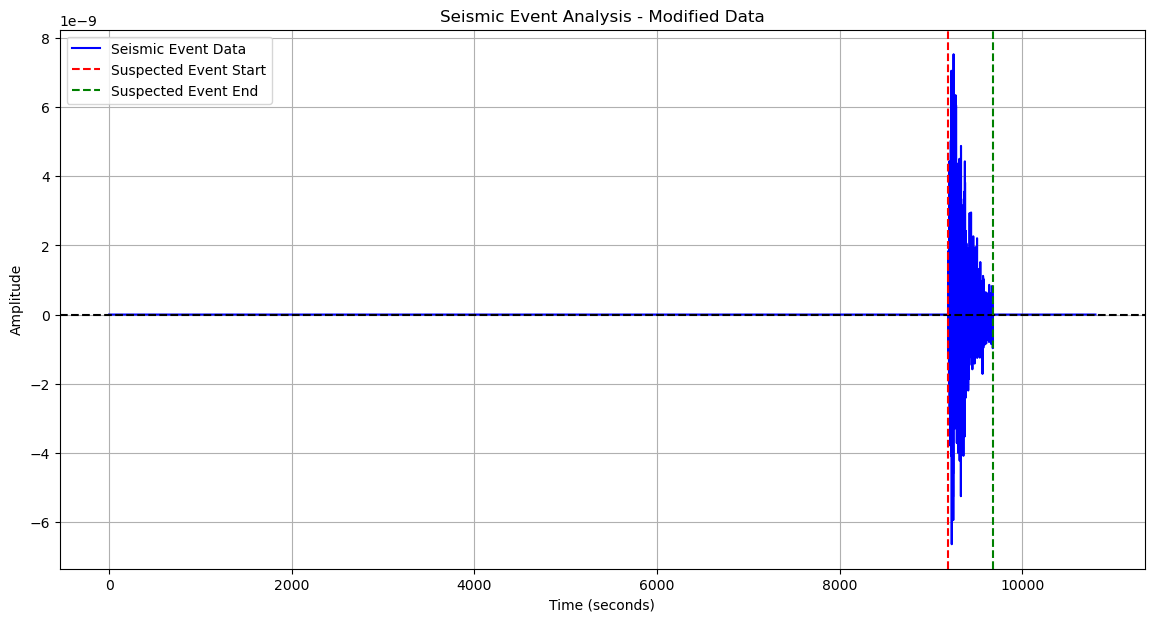

Modified wavelet coefficients saved to 'modified_wavelet_coefficients.csv'.
The suspected start of the seismic event is at: 9187.924528 seconds
The suspected end of the seismic event is at: 9676.830189 seconds


In [11]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# Load wavelet coefficients
wavelet_df = pd.read_csv('wavelet_coefficients_by_level.csv')

# Extract coefficients for levels 4, 5, and 6
level_4 = wavelet_df['wavelet_coefficients_level_4'].dropna().values
level_5 = wavelet_df['wavelet_coefficients_level_5'].dropna().values
level_6 = wavelet_df['wavelet_coefficients_level_6'].dropna().values

# Ensure the same length for all levels (padding)
min_length = min(len(level_4), len(level_5), len(level_6))
level_4 = level_4[:min_length]
level_5 = level_5[:min_length]
level_6 = level_6[:min_length]

# Combine coefficients
combined_coeffs = level_4 + level_5 + level_6

# Smooth the combined data
smoothed_data = gaussian_filter1d(combined_coeffs, sigma=2)

# Create time series for plotting
time_rel = wavelet_df['time_rel(sec)'].dropna().values[:min_length]

# Set a higher threshold for peak detection
mean_value = np.mean(smoothed_data)
std_value = np.std(smoothed_data)

# Increase the multiplier significantly to further reduce false positives
threshold_value = mean_value + 4 * std_value  # Try increasing to 4 or 5
minimum_peak_height = threshold_value  # Set a minimum height for detected peaks
minimum_peak_width = 10  # Set minimum width for detected peaks

# Find peaks to mark the start of seismic events
peaks, properties = find_peaks(smoothed_data, height=minimum_peak_height, distance=50, width=minimum_peak_width)

# Check if any peaks are found and use the first one for marking
event_start = peaks[0] if len(peaks) > 0 else None

# Set a threshold for end detection
threshold = mean_value - 2.5 * std_value  # Adjust this value to your data characteristics

# Start from the end of the signal and look for the end of the event
for i in range(min_length - 1, 0, -1):
    # Check if the amplitude is below the threshold for stability
    if smoothed_data[i] < threshold:
        event_end = i
        break
else:
    event_end = None

# Create a modified data array to replace data outside the start and end
modified_data = np.zeros_like(smoothed_data)

if event_start is not None and event_end is not None:
    # Keep the values within the event start and end range
    modified_data[event_start:event_end + 1] = smoothed_data[event_start:event_end + 1]

# Create a time series for plotting the modified data
modified_time = time_rel  # Keep original time for plotting

# Remove rows where wavelet coefficients are zero
filtered_df = pd.DataFrame({
    'time_rel(sec)': modified_time,
    'modified_wavelet_coefficients': modified_data
})

# Filter out rows where modified_wavelet_coefficients are zero
filtered_df = filtered_df[filtered_df['modified_wavelet_coefficients'] != 0]

# Plot the modified data with a horizontal line at y=0
plt.figure(figsize=(14, 7))
plt.plot(modified_time, modified_data, label='Seismic Event Data', color='blue')  # Changed to blue
plt.axhline(y=0, color='black', linestyle='--')  # Removed label for y=0 line
if event_start is not None:
    plt.axvline(x=modified_time[event_start], color='red', label='Suspected Event Start', linestyle='--')
if event_end is not None:
    plt.axvline(x=modified_time[event_end], color='green', label='Suspected Event End', linestyle='--')

plt.title('Seismic Event Analysis - Modified Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

# Save the filtered signal and time to CSV
filtered_df.to_csv('modified_wavelet_coefficients.csv', index=False)
print("Modified wavelet coefficients saved to 'modified_wavelet_coefficients.csv'.")

# Check the x-values where the event start and end lines are drawn
if event_start is not None:
    event_start_time = time_rel[event_start]
    print(f"The suspected start of the seismic event is at: {event_start_time} seconds")
else:
    print("No event start detected.")

if event_end is not None:
    event_end_time = time_rel[event_end]
    print(f"The suspected end of the seismic event is at: {event_end_time} seconds")
else:
    print("No event end detected.")

In [154]:
###########################Fourier is still amazing#############################
